In [1]:
%matplotlib inline

In [2]:
import netCDF4 as nc
import numpy as np

import pandas as pd
import geopandas
from shapely.geometry import Point

import matplotlib.pyplot as plt

import xarray as xr
from mpl_toolkits.basemap import Basemap

# PG modules
from country_bounding_boxes import country_bounding_boxes

In [3]:
debug = True

In [4]:

def roll_longitude(filename):
    tmp = xr.open_dataset(filename)
    lon_name = 'longitude'  # whatever name is in the data
    # Adjust lon values to make sure they are within (-180, 180)
    tmp['_longitude_adjusted'] = xr.where(
    tmp[lon_name] > 180,
    tmp[lon_name] - 360,
    tmp[lon_name])

    # reassign the new coords to as the main lon coords
    # and sort DataArray using new coordinate values
    tmp = (
        tmp
        .swap_dims({lon_name: '_longitude_adjusted'})
        .sel(**{'_longitude_adjusted': sorted(tmp._longitude_adjusted)})
        .drop(lon_name))
    tmp = tmp.rename({'_longitude_adjusted': lon_name})
    return tmp

In [91]:
# read in some cmip6 data for plotting
o3 = roll_longitude('cmip6_data/u-be647_ann_mean_surface_level_o3_rolled_lon.nc')
# note to self - these data are in MMR
RMM_AIR = 28.97 # g mol-1
RMM_OZONE = 47.997 # g mol-1
MMR_to_PPBV = RMM_AIR/RMM_OZONE*1e9
o3.o3.values = o3.o3.values*MMR_to_PPBV

In [92]:
# workout the bounding boxs for china
cnbounding = country_bounding_boxes['CN']
blon = cnbounding[1][0]
llat = cnbounding[1][1]
ulon = cnbounding[1][2]
rlat = cnbounding[1][3]
if debug:
    print(cnbounding)

('China', (73.6753792663, 18.197700914, 135.026311477, 53.4588044297))


In [93]:
lonbounds = [ blon, ulon]
latbounds = [ llat, rlat ] # degrees east ? 

lats = o3['latitude'].values[:] 
lons = o3['longitude'].values[:]

# find latitude index values that correspond to upper lower and upper latitude bounds
latli = np.argmin( np.abs( lats - latbounds[0] ) )
latui = np.argmin( np.abs( lats - latbounds[1] ) ) 

# find longitude index values that correspond to upper lower and upper longitude bounds
lonli = np.argmin( np.abs( lons - lonbounds[0] ) )
lonui = np.argmin( np.abs( lons - lonbounds[1] ) )  

/opt/anaconda3/envs/basemap/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


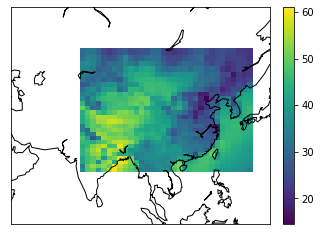

In [95]:
# quick visualisation to make sure that data extraction is gemutlich
map = Basemap(projection='merc',llcrnrlat=0,urcrnrlat=60, llcrnrlon=50,urcrnrlon=140,lat_ts=20,resolution='c')
map.drawcoastlines()

# need to make a meshgrid of lats and lons for use in Basemap
lonx, laty = np.meshgrid(lons[lonli:lonui], lats[latli:latui])
x, y = map(lonx, laty)

# can now plot
cs = map.pcolormesh(x,y,o3.o3[0,0,latli:latui,lonli:lonui])
plt.colorbar(fraction=0.046, pad=0.04)

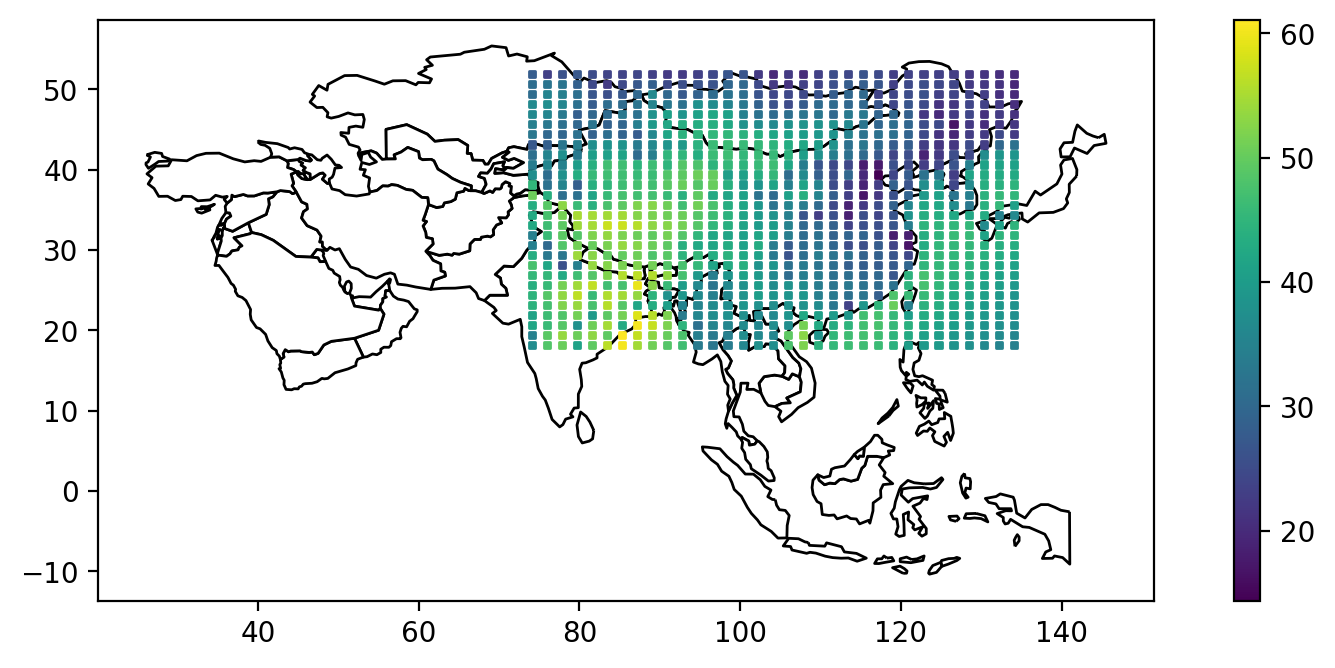

In [96]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
# create dataframe from netcdf file
o3df = o3['o3'][0,0,latli:latui,lonli:lonui].to_dataframe()
o3df = o3df.reset_index()
geom = [Point(x,y) for x, y in zip(o3df['longitude'], o3df['latitude'])]
o3gdf = geopandas.GeoDataFrame(o3df, geometry=geom)

plt.figure(figsize=(7.5,5), dpi=200)
ax = plt.subplot(1,1,1)
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world[world.continent == 'Asia'].plot(color='white',  edgecolor='black', ax=ax, legend=True,legend_kwds={'label': "Population by Country", 'orientation': "horizontal"})
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2.5%", pad=0.4)
# We restrict to Asia.
o3gdf.plot(ax=ax, markersize=5, marker='s', column='o3', cax=cax, legend=True)
plt.show()

In [97]:
chinese_cities = geopandas.read_file('shapefiles/bou2_4p.shp', encoding='GBK')
chinese_provinces = geopandas.sjoin(o3gdf, chinese_cities, op='within')

/opt/anaconda3/envs/basemap/lib/python3.6/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != {})
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [98]:
cities

,AREA,PERIMETER,BOU2_4M_,BOU2_4M_ID,ADCODE93,ADCODE99,NAME,geometry
0,54.447,68.489,2,23,230000,230000,黑龙江省,"POLYGON ((121.48844 53.33265, 121.49954 53.336..."
1,129.113,129.933,3,15,150000,150000,内蒙古自治区,"POLYGON ((121.48844 53.33265, 121.49738 53.321..."
2,175.591,84.905,4,65,650000,650000,新疆维吾尔自治区,"POLYGON ((96.38329 42.72696, 96.35991 42.70969..."
3,21.315,41.186,5,22,220000,220000,吉林省,"POLYGON ((123.17104 46.24668, 123.21857 46.269..."
4,15.603,38.379,6,21,210000,210000,辽宁省,"POLYGON ((123.69019 43.37677, 123.70496 43.381..."
...,...,...,...,...,...,...,...,...
920,0.000,0.037,922,3110,810000,810000,香港特别行政区,"POLYGON ((114.24527 22.18337, 114.24348 22.184..."
921,0.000,0.018,923,3109,810000,810000,香港特别行政区,"POLYGON ((114.28620 22.18478, 114.28435 22.185..."
922,0.000,0.014,924,3112,810000,810000,香港特别行政区,"POLYGON ((114.30350 22.18492, 114.30413 22.186..."
923,0.000,0.079,925,3114,810000,810000,香港特别行政区,"POLYGON ((114.25628 22.16027, 114.25436 22.163..."


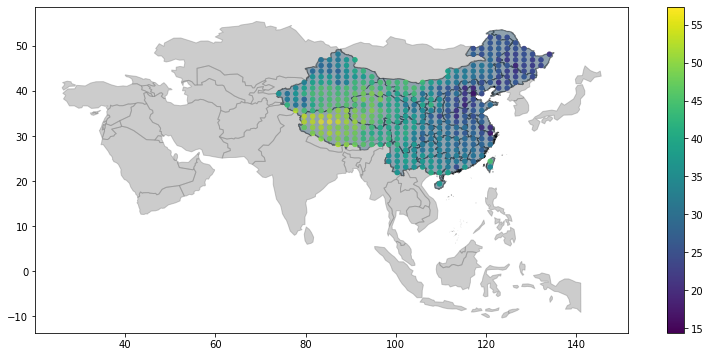

In [100]:
plt.figure(figsize=(14,6))
ax = plt.subplot(1,1,1)
world[world.continent == 'Asia'].plot(color='gray', alpha=0.4,edgecolor='gray', ax=ax)
cities.plot(ax=ax, color='gray', alpha=0.4,edgecolor='black')
# We can now plot our GeoDataFrame.
chinese_provinces.plot(markersize=20,ax=ax, column='o3', legend=True)
cities.plot(ax=ax, alpha=0.2)

In [69]:
for province in chinese_provinces.NAME.unique():
    emiss = chinese_provinces[chinese_provinces['NAME']==province]['o3']
    # replace with group
    chinese_provinces.loc[chinese_provinces['NAME'] == province, 'emiss'] = emiss


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


<Figure size 432x288 with 0 Axes>

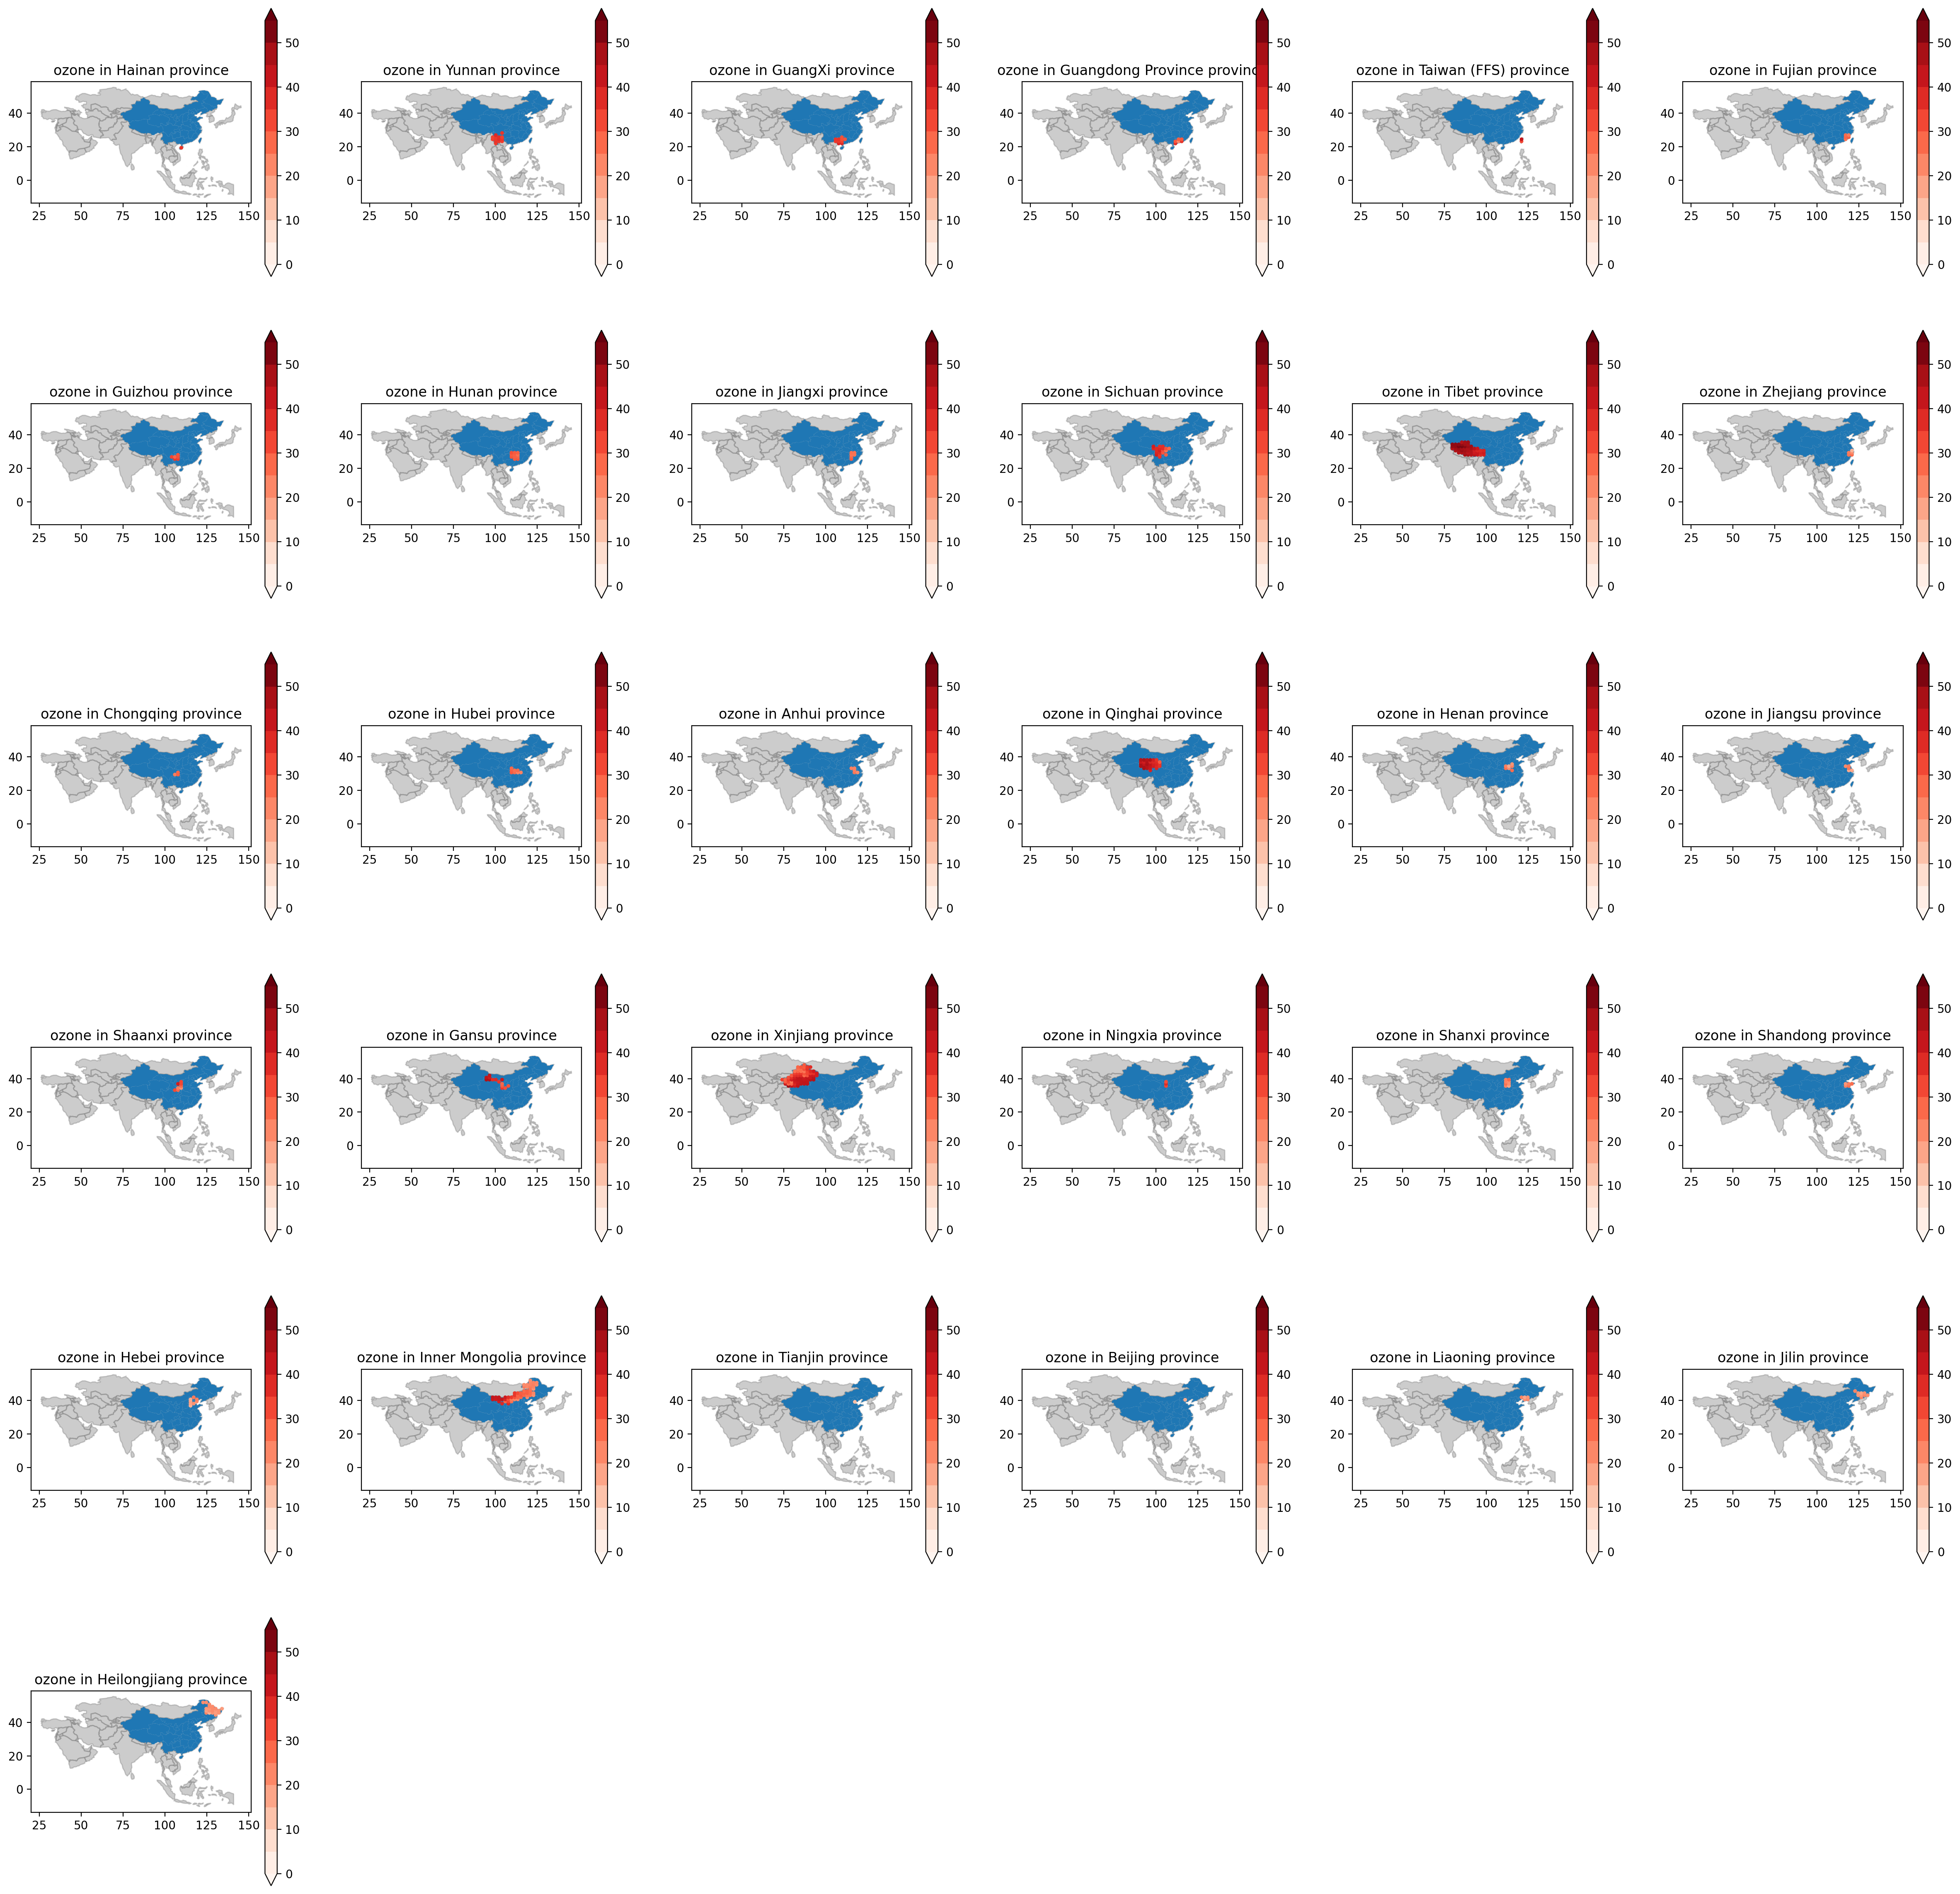

<Figure size 432x288 with 0 Axes>

In [75]:
plotvar=1
Z = [[0,0],[0,0]]
levels = np.arange(0,60,5)
CS3 = plt.contourf(Z, levels, cmap=plt.cm.Reds,extend='both')
plt.colorbar(CS3 )
plt.clf()
plt.figure(figsize=(30,30),dpi=200)
for provname in chinese_provinces.NAME.unique():
    print(plotvar)
    ax2 = plt.subplot(6,6,plotvar)
    world[world.continent == 'Asia'].plot(color='gray', alpha=0.4,edgecolor='gray', ax=ax2)
    cities.plot(ax=ax2)#, color='gray', alpha=0.4,edgecolor='black')
    chinese_provinces[chinese_provinces['NAME']==provname].plot(ax=ax2, markersize=5, c=rgb, column='o3', cmap=plt.cm.Reds, vmin=0, vmax=60)
    plt.title(u"ozone in "+china[provname]+" province")
    plt.colorbar(CS3, extend='upper')
    plotvar=plotvar+1
plt.show()
plt.savefig('/Users/ptg21/Desktop/china_emissions.png')